In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
from IPython.display import display, Markdown
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn

<h1>1. Выполните описательный анализ (распределение показателей, корреляции с целевым
показателем, пропуски, аномалии). При необходимости проведите предобработку.</h1>

<h3>Для анализа был выбран датасет Car price prediction (audi) - <a>https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes/</a>.
Он содержит 9 показателей, целевым является цена автомобиля - показатель price. Присутствуют качественные показатели model, transmission, fuelType, year и количественные показатели mileage, tax, mpg, engineSize.</h3>

In [2]:
df = pd.read_csv('audi.csv')
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...
10663,A3,2020,16999,Manual,4018,Petrol,145,49.6,1.0
10664,A3,2020,16999,Manual,1978,Petrol,150,49.6,1.0
10665,A3,2020,17199,Manual,609,Petrol,150,49.6,1.0
10666,Q3,2017,19499,Automatic,8646,Petrol,150,47.9,1.4


<h3>Рассмотрим распеделение некоторых показателей</h3>

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'mileage'}>,
        <Axes: title={'center': 'mpg'}>],
       [<Axes: title={'center': 'engineSize'}>,
        <Axes: title={'center': 'tax'}>]], dtype=object)

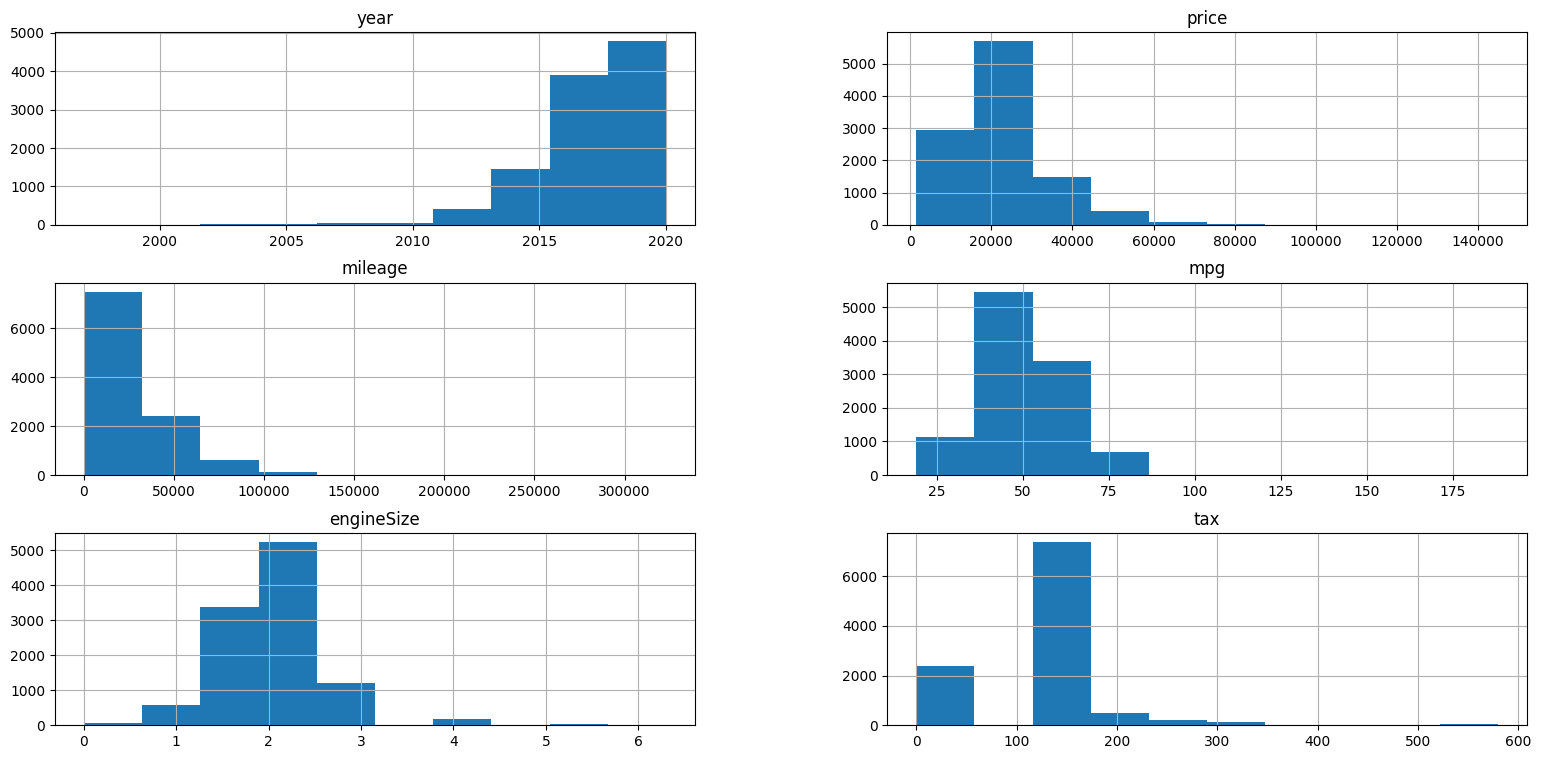

In [3]:
df[['year', 'price', 'mileage', 'mpg', 'engineSize', 'tax']].hist(figsize=(19, 9))

In [4]:
df['fuelType'].value_counts()

fuelType
Diesel    5577
Petrol    5063
Hybrid      28
Name: count, dtype: int64

In [5]:
df['model'].value_counts()

model
 A3     1929
 Q3     1417
 A4     1381
 A1     1347
 A5      882
 Q5      877
 Q2      822
 A6      748
 Q7      397
 TT      336
 A7      122
 A8      118
 Q8       69
 RS6      39
 RS3      33
 RS4      31
 RS5      29
 R8       28
 S3       18
 SQ5      16
 S4       12
 SQ7       8
 S8        4
 S5        3
 A2        1
 RS7       1
Name: count, dtype: int64

In [6]:
df['transmission'].value_counts()

transmission
Manual       4369
Semi-Auto    3591
Automatic    2708
Name: count, dtype: int64

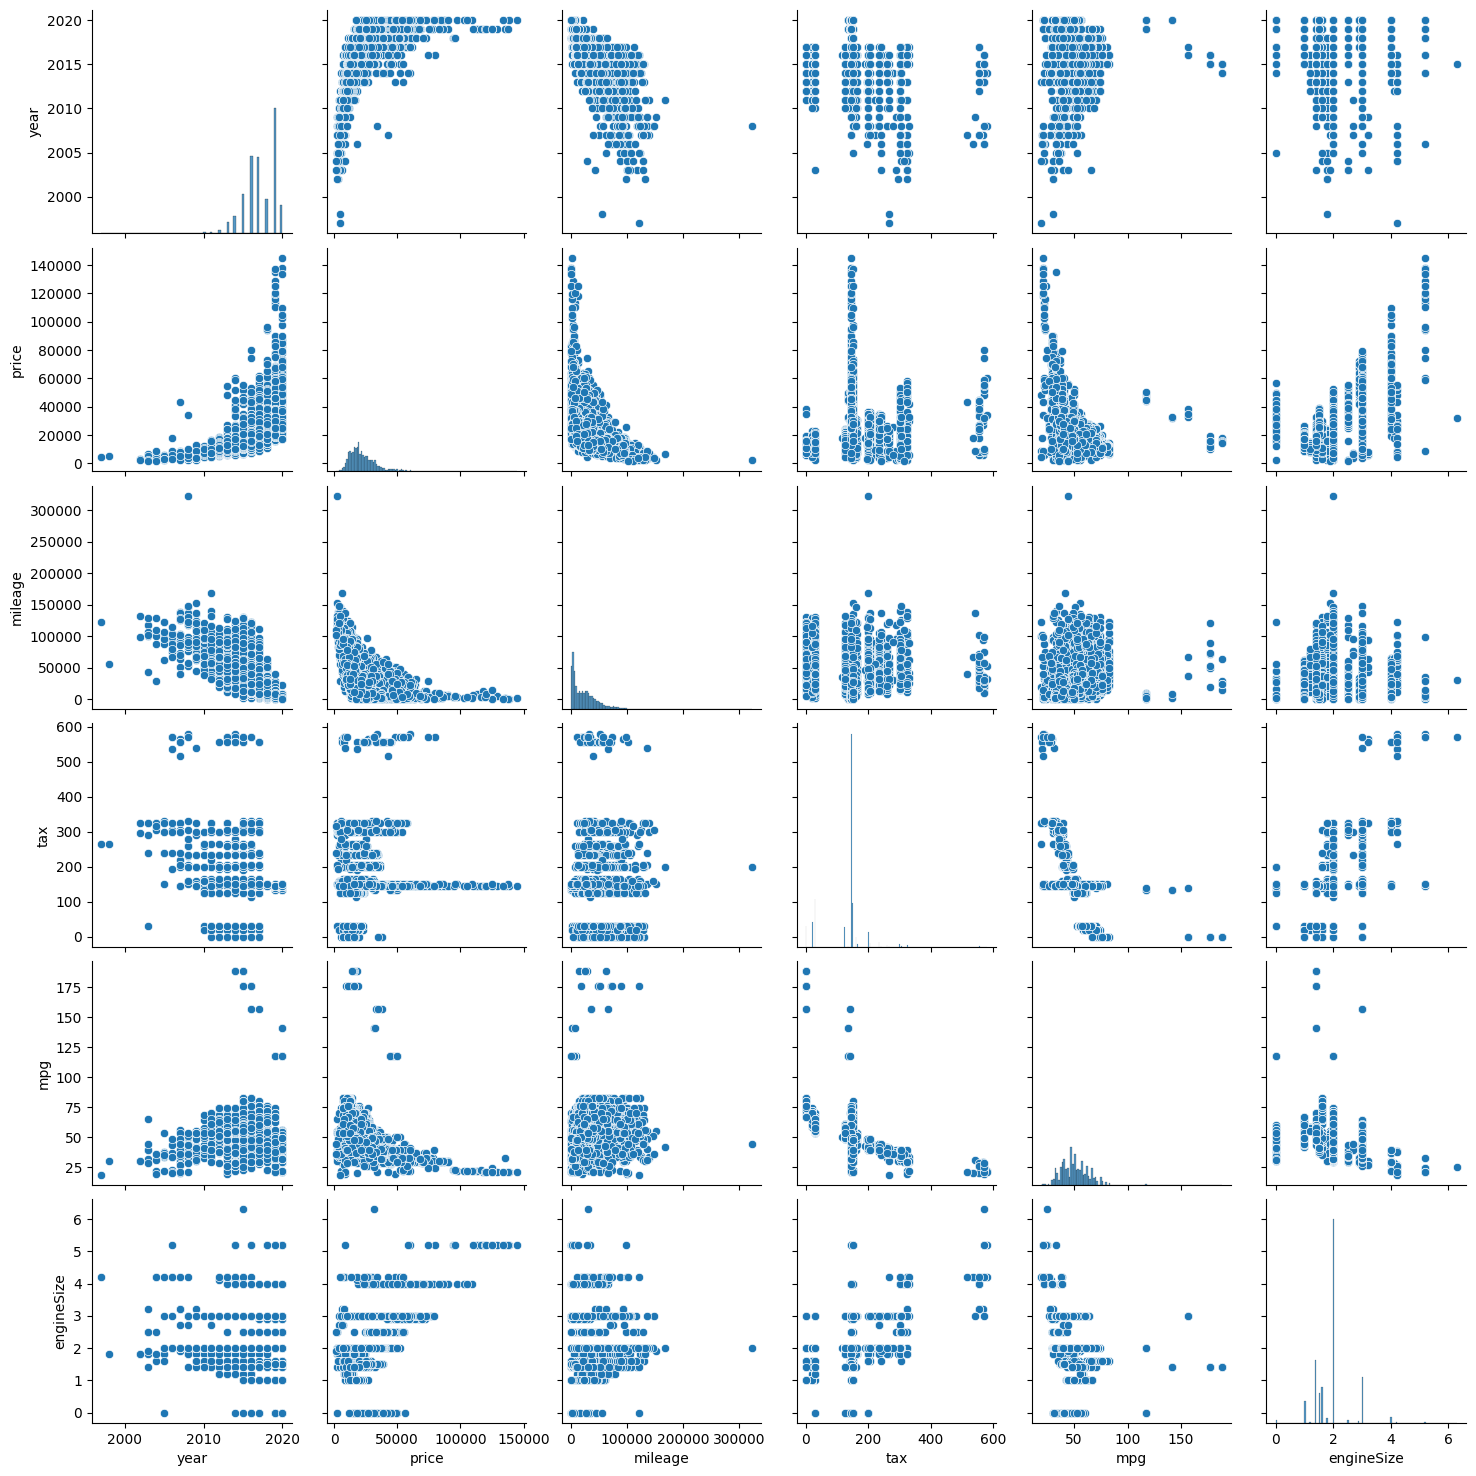

In [7]:
seaborn.pairplot(df)

<h3>Проведем бинаризацию качественных показателей для построения hitmapа(так как показатель model принимает 26 различных значений, мы вынуждены опустить его при построении графика корреляции между показателями)</h3>

In [8]:

binarised_df = pd.get_dummies(df.drop(columns=['model']), columns=['fuelType', 'transmission'], dtype=int)
binarised_df

,year,price,mileage,tax,mpg,engineSize,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol,transmission_Automatic,transmission_Manual,transmission_Semi-Auto
0,2017,12500,15735,150,55.4,1.4,0,0,1,0,1,0
1,2016,16500,36203,20,64.2,2.0,1,0,0,1,0,0
2,2016,11000,29946,30,55.4,1.4,0,0,1,0,1,0
3,2017,16800,25952,145,67.3,2.0,1,0,0,1,0,0
4,2019,17300,1998,145,49.6,1.0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10663,2020,16999,4018,145,49.6,1.0,0,0,1,0,1,0
10664,2020,16999,1978,150,49.6,1.0,0,0,1,0,1,0
10665,2020,17199,609,150,49.6,1.0,0,0,1,0,1,0
10666,2017,19499,8646,150,47.9,1.4,0,0,1,1,0,0


<Axes: >

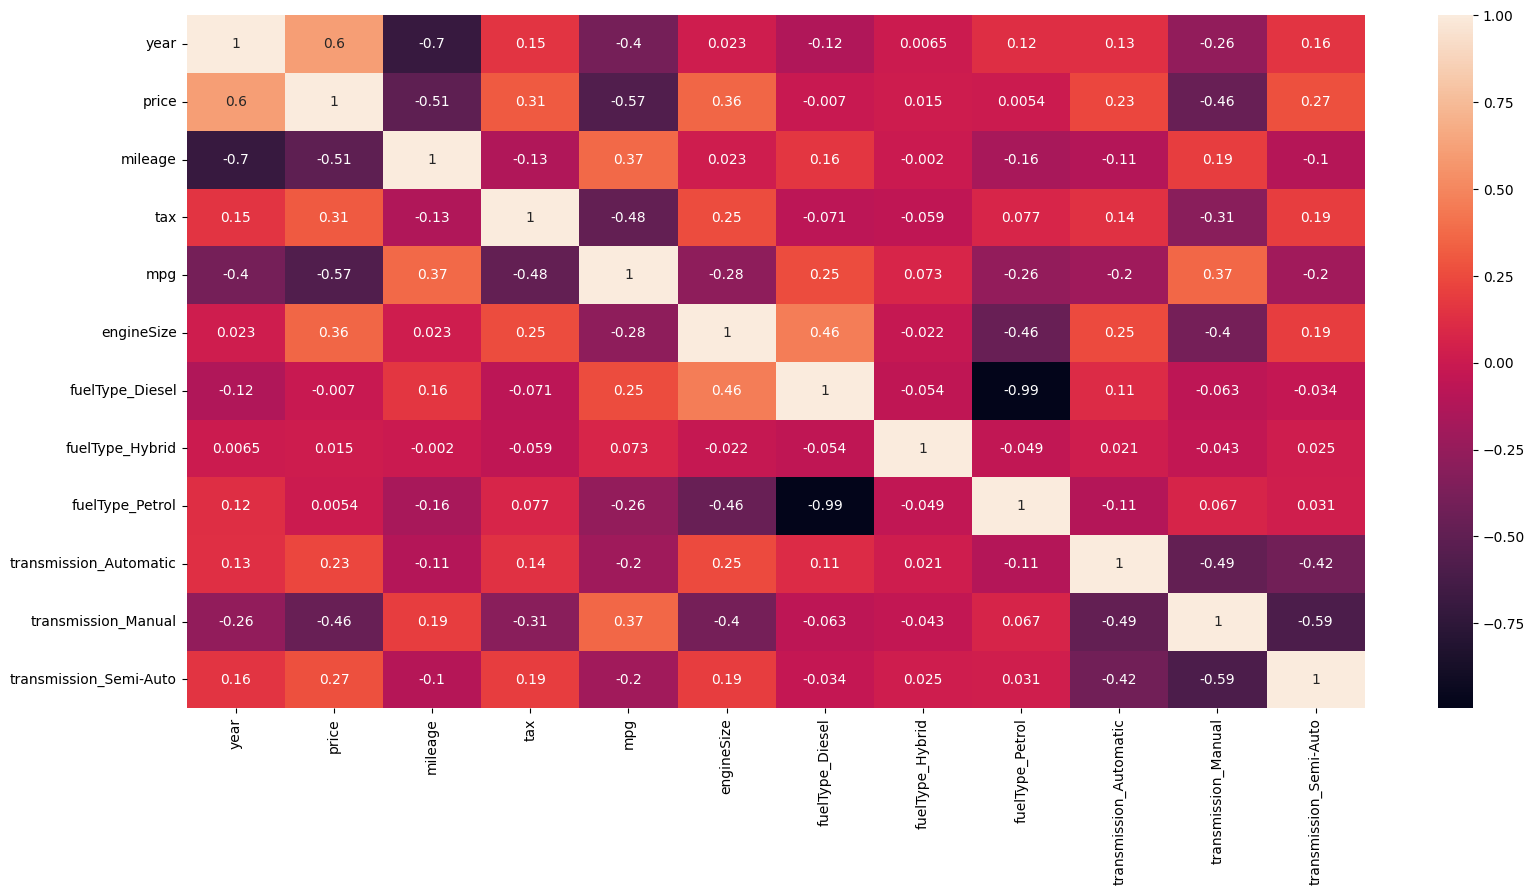

In [9]:
plt.figure(figsize=(19, 9))
seaborn.heatmap(binarised_df.corr(method='kendall'), annot=True)

<h1>2. Постройте базовые регрессионные модели</h1>

In [10]:
binarised_data_with_model = pd.get_dummies(df, columns=['fuelType', 'transmission'])
X=binarised_data_with_model.drop(columns=['price'])
Y=binarised_data_with_model.price
X_train, X_test, Y_train,Y_test=train_test_split(X,Y, test_size=0.2, random_state=10)
print("Размер обучающей выборки X:", X_train.shape)
print("Размер обучающей выборки Y:", Y_train.shape)
print("Размер тестовой выборки X:", X_test.shape)
print("Размер тестовой выборки Y:", Y_test.shape)

Размер обучающей выборки X: (8534, 12)
Размер обучающей выборки Y: (8534,)
Размер тестовой выборки X: (2134, 12)
Размер тестовой выборки Y: (2134,)


<h3>Constant</h3>

In [11]:
constant_Y = np.empty(Y_test.shape, dtype=float)
constant_Y.fill(Y_test.mean())
print("Средняя ошибка прогноза на тестовой выборке: ", mae(Y_test, constant_Y))
constant_Y = np.empty(Y_train.shape,dtype=float)
constant_Y.fill(Y_train.mean())
print("Средняя ошибка прогноза на обучающей выборке: ", mae(Y_train, constant_Y))

Средняя ошибка прогноза на тестовой выборке:  8225.40830038762
Средняя ошибка прогноза на обучающей выборке:  8427.915272833865


<h3>Constant by model</h3>

In [12]:
binarised_data_with_model['priceByModel'] = binarised_data_with_model.groupby('model')['price'].transform('mean')
X=binarised_data_with_model.drop(columns=['price'])
Y=binarised_data_with_model.price
X_train, X_test, Y_train,Y_test=train_test_split(X,Y, test_size=0.2, random_state=10)
print("Средняя ошибка прогноза на тестовой выборке: ", mae(Y_test, X_test.priceByModel))
print("Средняя ошибка прогноза на обучающей выборке: ", mae(Y_train, X_train.priceByModel))

Средняя ошибка прогноза на тестовой выборке:  5952.631973510042
Средняя ошибка прогноза на обучающей выборке:  6131.808318395758


<h3>OneParameterModel(by year)</h3>

In [13]:
LR_One=LinearRegression()
X=binarised_data_with_model.drop(columns=['price'])
Y=binarised_data_with_model.price
X_train, X_test, Y_train,Y_test=train_test_split(X,Y, test_size=0.2, random_state=10)
X_train_one_parameter=X_train[["year"]].values.reshape(-1,1)
X_test_one_parameter=X_test[["year"]].values.reshape(-1,1)
LR_One.fit(X_train_one_parameter,Y_train)
Y_test_predict = LR_One.predict(X_test_one_parameter)
Y_train_predict = LR_One.predict(X_train_one_parameter)
print("Средняя ошибка прогноза на тестовой выборке: ",mae(Y_test, Y_test_predict))
print("Средняя ошибка прогноза на тестовой выборке: ",mae(Y_train, Y_train_predict))

Средняя ошибка прогноза на тестовой выборке:  6040.77239524961
Средняя ошибка прогноза на тестовой выборке:  6145.319561940547


<h1>3. Постройте линейные регрессионные модели для прогноза целевого показателя</h1>

<h3>Без нормализации</h3>

In [14]:
full_binarized_data = pd.get_dummies(df, columns=['fuelType', 'transmission', 'model'], dtype=int)
X=full_binarized_data.drop(columns=['price'])
Y=full_binarized_data.price
X_train, X_test, Y_train,Y_test=train_test_split(X,Y, test_size=0.2, random_state=10)
LR_without_normalization=LinearRegression()
LR_without_normalization.fit(X_train,Y_train)
Y_test_predict=LR_without_normalization.predict(X_test)
Y_train_predict=LR_without_normalization.predict(X_train)
display(Markdown(f"<h4>Средняя ошибка прогноза на тестовой выборке: {mae(Y_test, Y_test_predict)}</h4>"))
display(Markdown(f"<h4>Средняя ошибка прогноза на обучающей выборке: {mae(Y_train, Y_train_predict)}</h4>"))
pd.Series(LR_without_normalization.coef_, index=X_train.columns)

<h4>Средняя ошибка прогноза на тестовой выборке: 2547.739955999054</h4>

<h4>Средняя ошибка прогноза на обучающей выборке: 2577.99037405121</h4>

year                       1837.735590
mileage                      -0.079130
tax                         -29.285804
mpg                        -281.432315
engineSize                 4604.350499
fuelType_Diesel          -10493.319304
fuelType_Hybrid           21837.151635
fuelType_Petrol          -11343.832331
transmission_Automatic      468.921975
transmission_Manual       -1054.141822
transmission_Semi-Auto      585.219847
model_ A1                -11746.216971
model_ A2                  7546.700863
model_ A3                -10443.092300
model_ A4                -10208.170129
model_ A5                 -8864.478926
model_ A6                 -8193.110757
model_ A7                 -7431.131231
model_ A8                 -3922.401227
model_ Q2                -10320.413207
model_ Q3                 -8855.099489
model_ Q5                 -4918.305285
model_ Q7                  3275.815507
model_ Q8                 12722.294219
model_ R8                 48300.629103
model_ RS3               

<h3>С нормализацией</h3>

In [15]:
std_scaler=StandardScaler()
X_train_normalised=std_scaler.fit_transform(X_train)
X_test_normalized=std_scaler.transform(X_test)
LR_normalised=LinearRegression()
LR_normalised.fit(X_train_normalised,Y_train)
Y_test_predict=LR_normalised.predict(X_test_normalized)
Y_train_predict=LR_normalised.predict(X_train_normalised)
display(Markdown(f"<h4>Средняя ошибка прогноза на тестовой выборке: {mae(Y_test, Y_test_predict)}</h4>"))
display(Markdown(f"<h4>Средняя ошибка прогноза на обучающей выборке: {mae(Y_train, Y_train_predict)}</h4>"))
pd.Series(LR_normalised.coef_, index=X_train.columns)

<h4>Средняя ошибка прогноза на тестовой выборке: 2547.7505686014897</h4>

<h4>Средняя ошибка прогноза на обучающей выборке: 2577.984908031775</h4>

year                      3.996227e+03
mileage                  -1.862579e+03
tax                      -1.979114e+03
mpg                      -3.635250e+03
engineSize                2.774221e+03
fuelType_Diesel           1.941419e+15
fuelType_Hybrid           1.970200e+14
fuelType_Petrol           1.941029e+15
transmission_Automatic    6.666692e+14
transmission_Manual       7.557383e+14
transmission_Semi-Auto    7.260017e+14
model_ A1                 1.496472e+14
model_ A2                 4.858633e+12
model_ A3                 1.722676e+14
model_ A4                 1.508147e+14
model_ A5                 1.229290e+14
model_ A6                 1.135118e+14
model_ A7                 4.782385e+13
model_ A8                 4.733894e+13
model_ Q2                 1.200701e+14
model_ Q3                 1.528755e+14
model_ Q5                 1.238878e+14
model_ Q7                 8.437187e+13
model_ Q8                 3.656131e+13
model_ R8                 2.425898e+13
model_ RS3               

<h3>Только на количественных показателях</h3>

In [16]:
quantitives = df[['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']]
X_q=quantitives.drop(columns=['price'])
Y_q=quantitives.price
X_train, X_test, Y_train,Y_test=train_test_split(X_q,Y_q, test_size=0.2, random_state=10)
LR_normalised=LinearRegression()
LR_normalised.fit(X_train,Y_train)
Y_test_predict=LR_normalised.predict(X_test)
Y_train_predict=LR_normalised.predict(X_train)
display(Markdown(f"<h4>Средняя ошибка прогноза на тестовой выборке: {mae(Y_test, Y_test_predict)}</h4>"))
display(Markdown(f"<h4>Средняя ошибка прогноза на обучающей выборке: {mae(Y_train, Y_train_predict)}</h4>"))
pd.Series(LR_normalised.coef_, index=X_train.columns)

<h4>Средняя ошибка прогноза на тестовой выборке: 3387.076424395916</h4>

<h4>Средняя ошибка прогноза на обучающей выборке: 3459.1937339006804</h4>

year           2062.327710
mileage          -0.096841
tax             -15.610713
mpg            -215.828444
engineSize    11084.314948
dtype: float64

<h1>4. Применение других регрессионных моделей</h1>

<h3>Полиномиальная регрессионная модель (с регуляризацией и без регуляризации)</h3>

<h4>Без регуляризации</h4>

In [17]:
PolyModel = LinearRegression()
poly = PolynomialFeatures(2, include_bias=False)

X = full_binarized_data.drop(columns=['price'])
Y = full_binarized_data.price
X_train, X_test, Y_train,Y_test = train_test_split(X,Y, test_size=0.2, random_state=10)

poly_X_train=poly.fit_transform(X_train)
scaled_poly_X_train=std_scaler.fit_transform(poly_X_train)
PolyModel.fit(scaled_poly_X_train, Y_train)

predictions_train = PolyModel.predict(scaled_poly_X_train)
display(Markdown(f"<h4>Средняя ошибка прогноза на обучающей выборке: {mae(Y_train, predictions_train)}</h4>"))

poly_X_test=poly.transform(X_test)
scaled_poly_X_test=std_scaler.transform(poly_X_test)
PolyModel.fit(scaled_poly_X_test, Y_test)
predictions_test = PolyModel.predict(scaled_poly_X_test)
display(Markdown(f"<h4>Средняя ошибка прогноза на тестовой выборке: {mae(Y_test, predictions_test)}</h4>"))

<h4>Средняя ошибка прогноза на обучающей выборке: 1753.5882868875626</h4>

<h4>Средняя ошибка прогноза на тестовой выборке: 1598.459817244611</h4>

<h4>С регуляризацией</h4>

In [18]:
from sklearn.linear_model import Lasso

LassoModel = Lasso()
poly = PolynomialFeatures(2, include_bias=False)

poly_X_train=poly.fit_transform(X_train)
scaled_poly_X_train=std_scaler.fit_transform(poly_X_train)
LassoModel.fit(scaled_poly_X_train, Y_train)
predictions_train = LassoModel.predict(scaled_poly_X_train)
display(Markdown(f"<h4>Средняя ошибка прогноза на обучающей выборке: {mae(Y_train, predictions_train)}</h4>"))

poly_X_test=poly.transform(X_test)
scaled_poly_X_test=std_scaler.transform(poly_X_test)
predictions_test = LassoModel.predict(scaled_poly_X_test)
display(Markdown(f"<h4>Средняя ошибка прогноза на тестовой выборке: {mae(Y_test, predictions_test)}</h4>"))

c:\Users\79270\Desktop\Zubr\enviroments\ml\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.335e+10, tolerance: 1.188e+08
  model = cd_fast.enet_coordinate_descent(


<h4>Средняя ошибка прогноза на обучающей выборке: 1850.5798953287228</h4>

<h4>Средняя ошибка прогноза на тестовой выборке: 1845.929143136409</h4>

<h3>Модель на основе дерева решений</h3>

In [19]:
Decision_Tree_model = DecisionTreeRegressor(random_state = 10, min_samples_leaf=3)
Decision_Tree_model.fit(X_train, Y_train)

predictions_train = Decision_Tree_model.predict(X_train)
display(Markdown(f"<h4>Средняя ошибка прогноза на обучающей выборке: {mae(Y_train, predictions_train)}</h4>"))

predictions_test = Decision_Tree_model.predict(X_test)
display(Markdown(f"<h4>Средняя ошибка прогноза на тестовой выборке: {mae(Y_test, predictions_test)}</h4>"))

pd.Series(Decision_Tree_model.feature_importances_,index=X_train.columns)

<h4>Средняя ошибка прогноза на обучающей выборке: 990.7303953188181</h4>

<h4>Средняя ошибка прогноза на тестовой выборке: 1770.78411880216</h4>

year                      0.232476
mileage                   0.024634
tax                       0.027385
mpg                       0.435734
engineSize                0.193699
fuelType_Diesel           0.001793
fuelType_Hybrid           0.002926
fuelType_Petrol           0.013159
transmission_Automatic    0.000334
transmission_Manual       0.025789
transmission_Semi-Auto    0.000656
model_ A1                 0.005027
model_ A2                 0.000000
model_ A3                 0.001822
model_ A4                 0.005273
model_ A5                 0.000761
model_ A6                 0.001343
model_ A7                 0.000770
model_ A8                 0.000927
model_ Q2                 0.000598
model_ Q3                 0.001844
model_ Q5                 0.005834
model_ Q7                 0.011665
model_ Q8                 0.002232
model_ R8                 0.000034
model_ RS3                0.000037
model_ RS4                0.000000
model_ RS5                0.000000
model_ RS6          

<h3>Модель на основе случайного леса</h3>

In [20]:
Random_Forest_model = RandomForestRegressor(random_state = 10, n_estimators = 50)
Random_Forest_model.fit(X_train, Y_train)

predictions_train = Random_Forest_model.predict(X_train)
display(Markdown(f"<h4>Средняя ошибка прогноза на обучающей выборке: {mae(Y_train, predictions_train)}</h4>"))

predictions_test = Random_Forest_model.predict(X_test)
display(Markdown(f"<h4>Средняя ошибка прогноза на тестовой выборке: {mae(Y_test, predictions_test)}</h4>"))

pd.Series(Random_Forest_model.feature_importances_,index=X_train.columns)

<h4>Средняя ошибка прогноза на обучающей выборке: 590.2635098038955</h4>

<h4>Средняя ошибка прогноза на тестовой выборке: 1506.4374124703527</h4>

year                      0.226279
mileage                   0.045176
tax                       0.022235
mpg                       0.435674
engineSize                0.170057
fuelType_Diesel           0.005051
fuelType_Hybrid           0.001056
fuelType_Petrol           0.005132
transmission_Automatic    0.001028
transmission_Manual       0.021471
transmission_Semi-Auto    0.001102
model_ A1                 0.005922
model_ A2                 0.000002
model_ A3                 0.002106
model_ A4                 0.002933
model_ A5                 0.001061
model_ A6                 0.001852
model_ A7                 0.000887
model_ A8                 0.001036
model_ Q2                 0.000750
model_ Q3                 0.001457
model_ Q5                 0.004808
model_ Q7                 0.009333
model_ Q8                 0.002032
model_ R8                 0.027599
model_ RS3                0.000172
model_ RS4                0.000222
model_ RS5                0.000086
model_ RS6          

<h1>5. Сопоставьте оценки важности показателей для разных моделей</h1>

<h3>Линейная регрессия с нормализацией</h3>

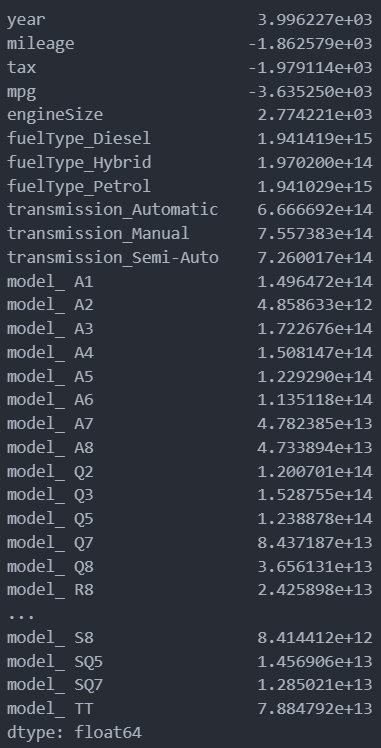

<h3>Модель на основе дерева решений</h3>

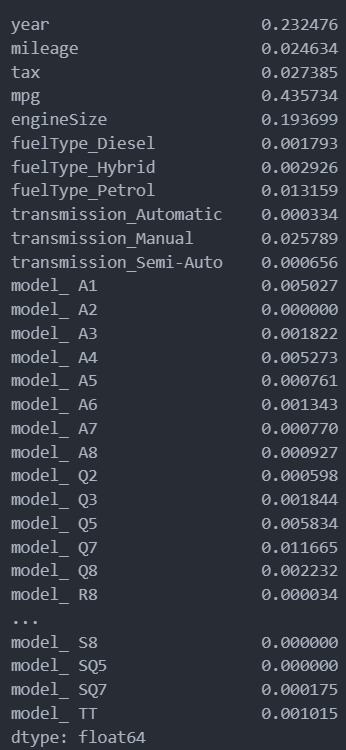

<h3>Модель на основе случайного леса</h3>

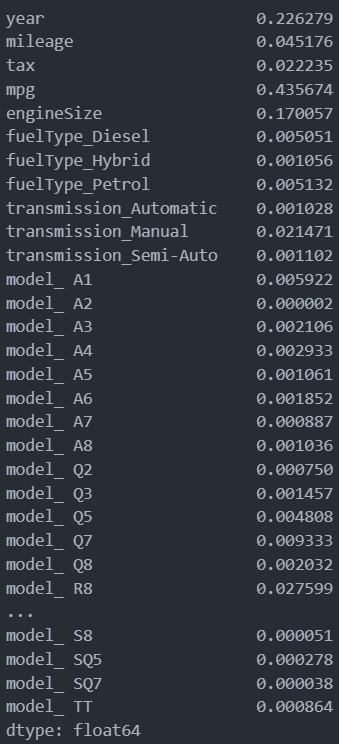

<h4>Наиболее важными показателями являются year, mpg, engineSize</h4>